In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# import constraint Learning Tool 
import sys
import os

sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl
import torch
from src.visualize import plot_two_turbine_results

from sklearn.model_selection import train_test_split

import itertools
import numpy as np

from sklearn.metrics import mean_squared_error
import numpy as np


In [2]:
data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,0.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,0.0,8.0,10.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,0.0,8.0,20.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,0.0,8.0,30.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,0.0,8.0,40.0,0.06,1753.954459,1753.954459,3507.908918


In [3]:
### Test/Train Split
# Split the data into training, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

# Define model
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]],
                    y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)


# optimize NN

Training with n_hidden=2, n_nodes=6
DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=6, bias=True)
    (1): Linear(in_features=6, out_features=6, bias=True)
  )
  (output_mean_layer): Linear(in_features=6, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 1.1182634830474854
epoch 500 loss 0.792560875415802
epoch 1000 loss 0.7476702332496643
epoch 1500 loss 0.660865068435669
epoch 2000 loss 0.6093366146087646
NN fitting process finished with a validation MSE loss of 0.58906489610672 in epoch 2485
Training with n_hidden=2, n_nodes=8
DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
  )
  (output_mean_layer): Linear(in_features=8, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-1): 2 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 1.1423680782318115
epoc

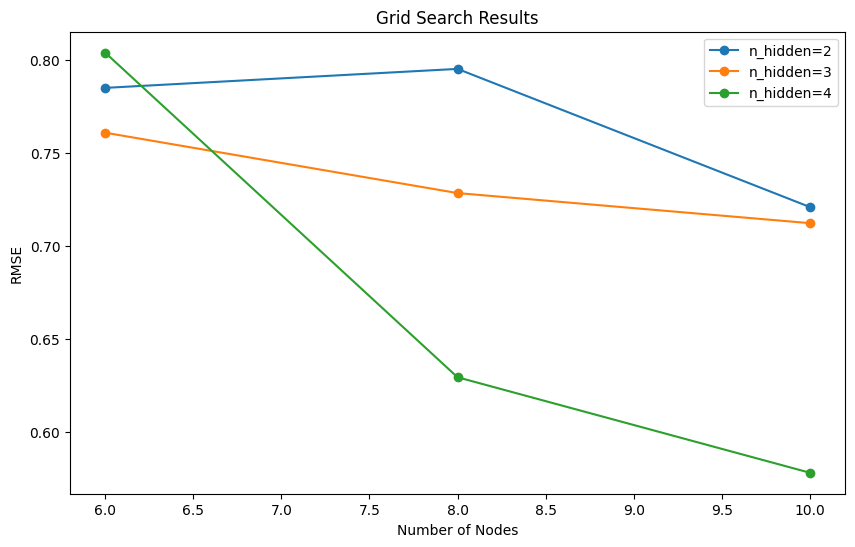

In [5]:
param_grid = {
    'n_hidden': [2, 3, 4],
    'n_nodes': [6, 8, 10]
}

best_params, best_rmse, grid_search = cl_tool.optimize_nn(param_grid = param_grid,iters = 2500,plot = True)

In [6]:
# Retrain the model with the best parameters
model, preds_test, y_test = cl_tool.train(n_hidden=4, n_nodes=8, iters=5000, drop=0.05, learning_rate=1e-4)

torch.save(model, "models/prob_extended.pth")

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1-3): 3 x Linear(in_features=8, out_features=8, bias=True)
  )
  (output_mean_layer): Linear(in_features=8, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-3): 4 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 1.2435343265533447
epoch 500 loss 0.5846511721611023
epoch 1000 loss 0.4999958276748657
epoch 1500 loss 0.4758985638618469
epoch 2000 loss 0.47135451436042786
epoch 2500 loss 0.4519489109516144
epoch 3000 loss 0.47595304250717163
epoch 3500 loss 0.45025351643562317
epoch 4000 loss 0.4495144784450531
epoch 4500 loss 0.464315801858902
NN fitting process finished with a validation MSE loss of 0.39506450295448303 in epoch 4267


# Predict for new data

In [ ]:
data["farm_power_pred"] = cl_tool.predict(X = data[["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"]])
data["error"] = data["farm_power_pred"] - data["farm_power"]
data["error_percent"] = data["error"] / data["farm_power"] * 100

In [ ]:
# Define the ranges for each feature
x_turb2_range = np.arange(0, 5001, 10)           # Example: 0 to 5000 in steps of 500
y_turb2_range = np.arange(0, 601, 10)            # Example: 0 to 600 in steps of 100
wind_speed_range = [8] #np.arange(6.0, 13.0, 2.0)      # Example: 6.0 to 12.0 in steps of 2.0
wind_direction_range = [270] #np.arange(0, 361, 90)      # Example: 0 to 360 in steps of 90
turbulence_intensity = [0.06]
# Generate all possible combinations
combinations = list(itertools.product(
    x_turb2_range,
    y_turb2_range,
    wind_speed_range,
    wind_direction_range,
    turbulence_intensity
))

# Create the DataFrame
generated_data = pd.DataFrame(combinations, columns=["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"])

# predict
pred_new = cl_tool.predict(X = generated_data[["x_turb2", "y_turb2", "wind_speed", "wind_direction","turbulence_intensity"]])
generated_data['pred'] = pred_new

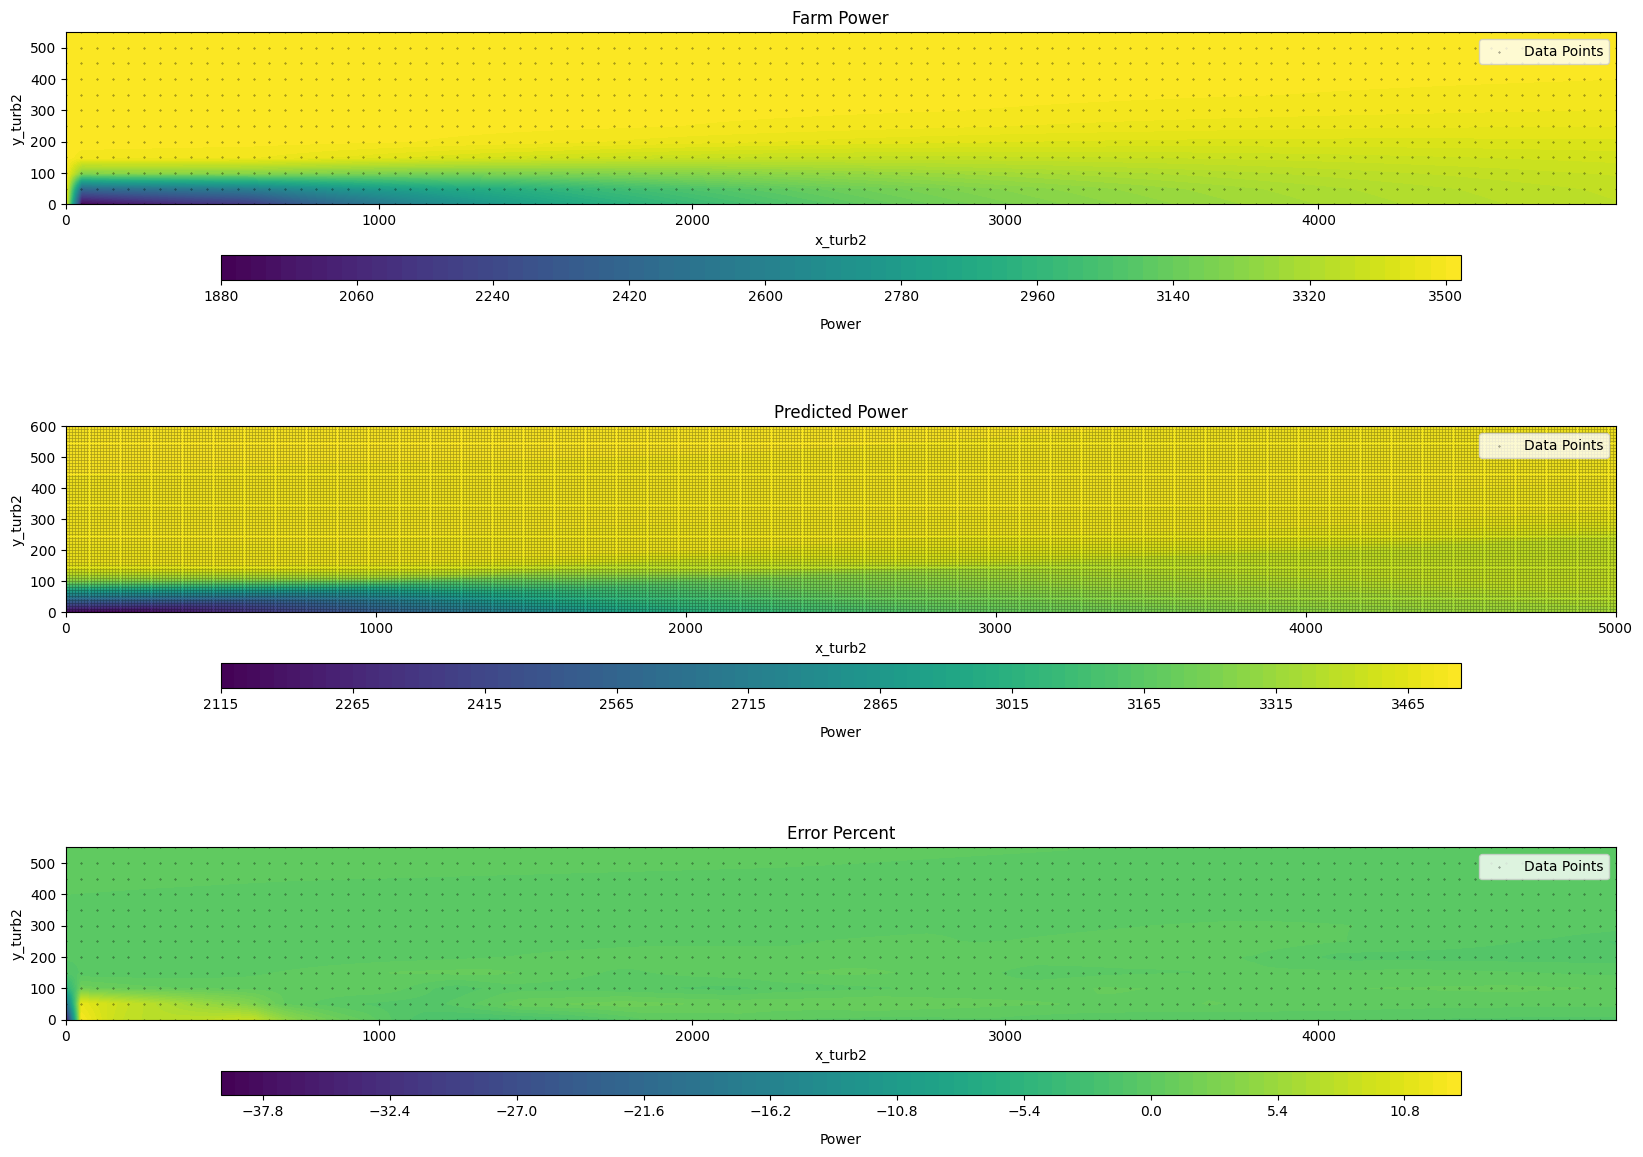

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(20, 15))

# Plot farm_power
plot_two_turbine_results(data, zfeature="farm_power", dpoint_size=0.1, ax=axes[0])
axes[0].set_title("Farm Power")

# Plot pred
plot_two_turbine_results(generated_data, zfeature="pred", dpoint_size=0.1, ax=axes[1])
axes[1].set_title("Predicted Power")

# Plot error_percent
plot_two_turbine_results(data, zfeature="error_percent", dpoint_size=0.1, ax=axes[2])
axes[2].set_title("Error Percent")

plt.show()

In [ ]:
generated_data[generated_data.pred == generated_data.pred.max()]

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,pred
60,0,600,8,270,0.06,3519.89917
